In [87]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
%matplotlib inline

In [2]:
dbname = 'taxi'
username='jgabor'

In [3]:
# Connect with the database

#con = None
#con = psycopg2.connect(database=dbname, user=username)
#cur = con.cursor()

engine = create_engine('postgresql://%s@localhost/%s' % (username, dbname))
print "ENGINE", engine.url

ENGINE postgresql://jgabor@localhost/taxi


In [9]:
# Try out a very simple query
sql = """SELECT pickup_longitude, pickup_latitude, pickup_datetime 
    FROM taxi_trips LIMIT 1000000"""
df1 = pd.read_sql_query(sql, engine, parse_dates=['pickup_datetime'])
df1.head()

,pickup_longitude,pickup_latitude,pickup_datetime
0,-73.9971,40.7512,2013-01-01 13:29:00
1,-73.9777,40.7423,2013-01-01 13:23:00
2,-73.9996,40.7329,2013-01-01 13:05:00
3,-73.9861,40.7541,2013-01-01 13:28:00
4,-73.9976,40.7256,2013-01-01 13:10:00


In [24]:
# Some quick examples with datetimes
ii = 500000
my_dt = df1['pickup_datetime'][ii]
print my_dt
print "Day of week (0=Monday): ", df1['pickup_datetime'][ii].dayofweek
print "week of year", df1['pickup_datetime'][ii].weekofyear
print "minute of the hour", my_dt.minute

2013-01-03 19:54:00
Day of week (0=Monday):  3
week of year 1
minute of the hour 54


In [40]:
# Query using datetime functions from PostgreSQL
sql = """
SELECT * FROM 
 (
  SELECT pickup_datetime, 
   60*EXTRACT(hour from pickup_datetime)+
     EXTRACT(minute from pickup_datetime) AS minute_of_day
  FROM taxi_trips
  LIMIT 10000
 ) AS temporary
 ORDER BY minute_of_day;
"""
df2 = pd.read_sql_query(sql, engine, parse_dates = ["pickup_datetime"])
df2.head()

,pickup_datetime,minute_of_day
0,2013-01-06,0
1,2013-01-06,0
2,2013-01-06,0
3,2013-01-06,0
4,2013-01-06,0


In [50]:
# Get 1 Million records with pickup location, hour-of-day
# ordered by hour-of-day
sql = """
SELECT * FROM 
 (
  SELECT pickup_datetime, 
   60*EXTRACT(hour from pickup_datetime) AS hour_of_day,
   pickup_longitude,
   pickup_latitude
  FROM taxi_trips
  LIMIT 5000000
 ) AS temporary
 ORDER BY hour_of_day;
"""
df2 = pd.read_sql_query(sql, engine, parse_dates = ["pickup_datetime"])
print df2.head()
print "MINMAX Dates:", df2['pickup_datetime'].min(), df2['pickup_datetime'].max()

      pickup_datetime  hour_of_day  pickup_longitude  pickup_latitude
0 2013-01-26 00:58:19            0          -74.0082          40.7145
1 2013-01-22 00:26:27            0          -74.0042          40.7422
2 2013-01-24 00:50:41            0          -73.9826          40.7539
3 2013-01-22 00:27:00            0          -73.9811          40.7417
4 2013-01-26 00:54:05            0          -73.9928          40.7396
MINMAX Dates: 2013-01-01 00:00:00 2013-01-31 23:59:20


In [51]:
print "MINMAX Dates:", df2['pickup_datetime'].min(), df2['pickup_datetime'].max()

MINMAX Dates: 2013-01-01 00:00:00 2013-01-31 23:59:20


In [74]:
# Count up how many we have for each hour
# (divide by 60 because we screwed it up earlier)
tt = df2['hour_of_day'] / 60
tally=0
for hh in range(24):
    w1 = (tt == hh)
    tally += w1.sum()
    print w1.sum(), tally

201738 201738
153593 355331
120043 475374
89898 565272
65380 630652
50458 681110
97317 778427
165461 943888
208313 1152201
220284 1372485
217572 1590057
226387 1816444
240537 2056981
247718 2304699
256510 2561209
247576 2808785
213882 3022667
247703 3270370
314177 3584547
316855 3901402
290090 4191492
283492 4474984
283566 4758550
241450 5000000


In [77]:
df2['pickup_latitude'][w1].head()

4758550    40.7364
4758551    40.7567
4758552    40.7475
4758553    40.7342
4758554    40.7417
Name: pickup_latitude, dtype: float64

In [128]:
def make_2dhist(lng, lat):
    """Make a 2d histogram from lat and long data"""
    # Length of 1 degree longitude divided by length
    # of 1 degree latitude (at latitude of NYC)
    aspect_geo = 52.52 / 69.0 
    
    coord_bottom_left = [-74.021759, 40.698861]
    coord_top_right = [-73.927689, 40.816927]
    imwidth_miles = (coord_top_right[0] - coord_bottom_left[0]) * 52.52
    imheight_miles = (coord_top_right[1] - coord_bottom_left[1]) * 69.0
    npix_base = 800
    npix = [npix_base, round(npix_base * imheight_miles / imwidth_miles)]
##    print "NPIX", npix
    
    xmin = lng.min()
    xmax = lng.max()
    ymin = lat.min()
    ymax = lat.max()
    
    print xmin, xmax, ymin, ymax
    
    imrange = [[coord_bottom_left[0], coord_top_right[0]],
              [coord_bottom_left[1], coord_top_right[1]] ]
    im,xedge,yedge = np.histogram2d(lng,lat,bins=npix, range=imrange)
                                #range=[[-74.05,-73.95],[40.7,40.84]])
                                #range=[[40.6,40.7],[-74.0,-73.5]])
##    print "im shape", im.shape
    #print xedge
    im = im.transpose()
    return im

In [129]:
# Loop through hours. For each hour of the day, create
# a 2d histogram of 
#!!!!!!!!!! Watch divide by 60 -- correcting earlier error
imlist = []
for myhour in range(24):
    w1 = (df2['hour_of_day'] / 60) == myhour

    lng = df2['pickup_longitude'][w1]
    lat = df2['pickup_latitude'][w1]
    
    w2 = (lat > 39.0) & (lat < 42.0) &\
        (lng > -75.0) & (lng < -70.0)
    lng = lng[w2]
    lat = lat[w2]
    
    im = make_2dhist(lng, lat)
    imlist.append(imlist)


-74.5361 -71.3094 40.0333 41.4537
-74.5655 -71.3085 40.05 41.4537
-74.6 -70.3667 39.3609 41.4
-74.9524 -72.4167 40.1168 41.104
-74.6393 -73.3426 40.2667 41.6904
-74.3298 -73.6591 40.5776 41.0691
-74.2249 -72.8934 40.2759 41.0468
-74.5862 -72.1 39.9798 41.7996
-74.5292 -71.95 39.7935 41.0319
-74.7667 -72.45 40.1667 41.2387
-74.6469 -72.4096 40.3972 41.9991
-74.36 -71.3333 40.1667 41.65
-74.7113 -73.1 40.3422 41.5
-74.7108 -70.6833 40.1 41.3155
-74.8488 -72.4667 39.5971 41.55
-74.6333 -70.5667 40.1333 41.6966
-74.95 -71.3 40.2167 41.5333
-74.6141 -71.3093 40.1 41.4667
-74.5446 -70.5091 39.1738 41.4537
-74.7833 -71.3 39.8904 41.5833
-74.55 -71.0333 39.9611 41.4537
-74.5 -71.3 39.4833 41.4537
-74.9167 -71.305 40.1437 41.5333
-74.9413 -71.3 39.6044 41.9333


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(imlist[5]), origin = 'low', aspect=1.0, cmap='Greens', clim=(-8,.2))
plt.xticks([])
plt.yticks([])
##plt.set_cmap("Green")
#im

##im
plt.savefig('test.pdf', bbox_inches='tight')

In [117]:
print np.max(np.log10(im)), np.min(np.log10(im))

1.95904139232 -inf


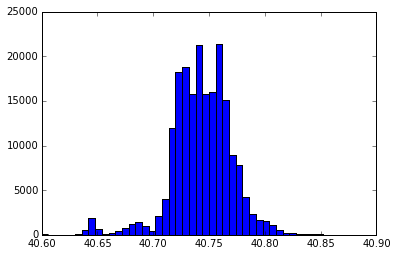

In [95]:
histo = plt.hist(lat, 50, range=(40.6,40.9))

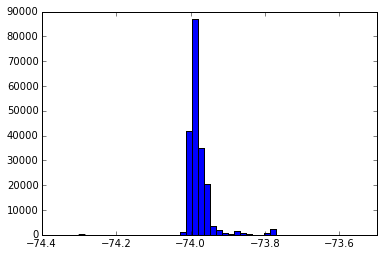

In [98]:
histo = plt.hist(lng, 50, range=(-74.3,-73.5))